In [ ]:
# (Bronte) Sihan Li, Cole Crescas 2023

In [1]:
# Imports

import torch
from ShadowAttack.shadow_attack import *
from ShadowAttack.utils import *
from resnet import ResNet

In [2]:
GTSRB_DIR = 'data/GTSRB_test/Final_Test/Images'
SHADOW_ATTACK_DIR = 'ShadowAttack'

In [ ]:
# Apply shadow attack

# Define attack parameters
shadow_level = 0.43
target_model = 'model_35'
attack_db = 'GTSRB'
attack_type = 'digital'
image_path = GTSRB_DIR
mask_path = f'{SHADOW_ATTACK_DIR}/mask'
image_label = 0
polygon = 3
n_try = 5

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

model = ResNet().to(device)
model.load_state_dict(
    torch.load(f'checkpoints/{target_model}.pth',
                map_location=torch.device(device)))
pre_process = transforms.Compose([ pre_process_image,
transforms.ToTensor(),
transforms.Resize((48, 48)),
transforms.Normalize((0.3337, 0.3064, 0.3171), ( 0.2672, 0.2564, 0.2629))])

model.eval()


assert attack_type in ['digital', 'physical']
if attack_type == 'digital':
    particle_size = 10
    iter_num = 10
    x_min, x_max = -16, 48
    max_speed = 1.5
else:
    particle_size = 10
    iter_num = 20
    x_min, x_max = -112, 336
    max_speed = 10.
    n_try = 1

# Digital shadow attack

save_dir = f'./adv_img/{attack_db}/{int(shadow_level*100)}'
os.makedirs(save_dir, exist_ok=True)

with open(f'{SHADOW_ATTACK_DIR}/dataset/{attack_db}/test.pkl', 'rb') as dataset:
    test_data = pickle.load(dataset)
    images, labels = test_data['data'], test_data['labels']
    print(type(images), type(labels))

print("Start attack on {} images".format(len(images)))
for index in range(len(images)):
    mask_type = judge_mask_type(attack_db, labels[index])
    if brightness(images[index], mask_list[mask_type]) >= 120:
        adv_img, success, num_query = attack(
            images[index], labels[index], position_list[mask_type],
            model=model, pre_process=pre_process,
            n_try=n_try, shadow_level=shadow_level, mask_path=mask_path,
            polygon=polygon, particle_size=particle_size, iter_num=iter_num,
            target=labels[index], x_min=x_min, x_max=x_max,
            )
        cv2.imwrite(f"{save_dir}/{index}_{labels[index]}_{num_query}_{success}.bmp", adv_img)

print("Attack finished! Success rate: ", end='')
print(Counter(map(lambda x: x[:-4].split('_')[-1],
                    os.listdir(save_dir)))['True'] / len(os.listdir(save_dir)))

In [2]:
import shutil, os

save_dir = f'./shadow_removed_ITSD_0.01'
# Process the adv images and put them into label folders
for img in os.listdir(save_dir):
    img_path = os.path.join(save_dir, img)
    label = img.split('_')[1]
    os.makedirs(os.path.join(save_dir, label), exist_ok=True)
    shutil.move(img_path, os.path.join(save_dir, label))

In [ ]:
# Process the original test imaegs and put them into label folders
import pandas as pd
import shutil, os

label_file = 'data/GTSRB_test/Final_Test/GT-final_test.csv'
label_map = pd.read_csv(label_file, sep=';')
for img in os.listdir(GTSRB_DIR):
    img_path = os.path.join(GTSRB_DIR, img)
    try:
        label = label_map.loc[int(img[:-4])]['ClassId']
    except:
        print(img)
        continue
    os.makedirs(os.path.join(GTSRB_DIR, str(label)), exist_ok=True)
    shutil.move(img_path, os.path.join(GTSRB_DIR, str(label)))

In [7]:
# Add dummy images to the label folders

import os
import shutil
import random
import numpy as np
from PIL import Image

root = f'./shadow_removed_AISTD_0.02'
classes = list(range(43))

# create empty image
empty_image = np.zeros((48, 48, 3))
empty_image = Image.fromarray(empty_image.astype('uint8')).convert('RGB')
empty_image.save('empty_image.jpg')

# Create dummy folders for missing classes
for c in classes:
    c = str(c)
    if not os.path.exists(os.path.join(root, c)):
        os.makedirs(os.path.join(root, c))
        shutil.copyfile('empty_image.jpg', os.path.join(root, c, 'empty_image.jpg'))

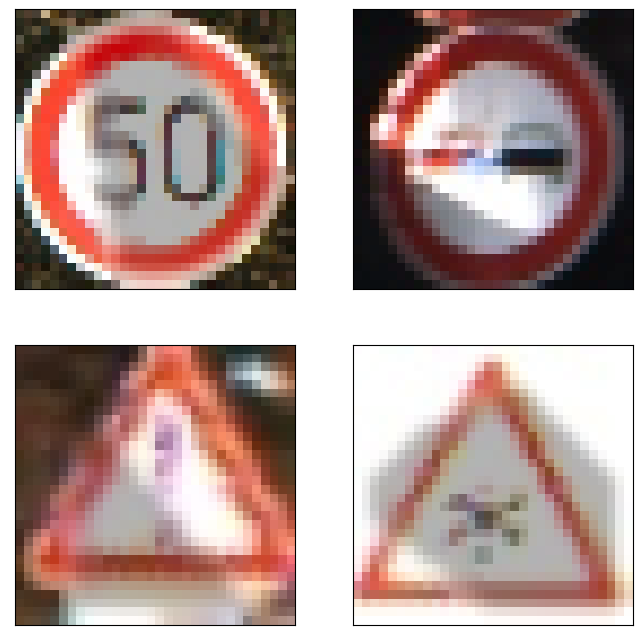

In [10]:
# Visualize images
import matplotlib.pyplot as plt
import os
import random
import numpy as np
from PIL import Image

data_dir = f'./adv_img/GTSRB/'

images = [
    '00002/6658_2_2000_False.bmp',
    '00009/12609_9_200_False.bmp',
    '00018/3566_18_2000_False.bmp',
    '00030/7068_30_2000_False.bmp'
]
# show images on the same plot
fig = plt.figure(figsize=(8, 8))
columns = 2
rows = 2
for i in range(1, columns*rows +1):
    img = Image.open(os.path.join(data_dir, images[i-1]))
    fig.add_subplot(rows, columns, i)
    # remove the tick marks
    plt.xticks([])
    plt.yticks([])
    plt.imshow(img)